In [1]:
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
from config import AlphaVan_key
from pathlib import Path
base_url = f'https://www.alphavantage.co/query?apikey={AlphaVan_key}'

# If you run this file you can only do 5 API calls per minute (Alpha Vantage throttles their API)
# You need to wait a full minute before running the 6th and further calls
# This will happen in this code, so pause while running it to make sure it completes

In [2]:
# Load data from specified file
def process_unemployment_data(file_path):
    df = pd.read_excel(file_path)
 
    # Delete the first 5 rows
    df = df.iloc[6:]
        
    # Created a list of new column names
    new_column_names = ['Characteristic', 
                        'Total', 
                        'Number', 
                        'Percent of Total', 
                        'Received Pay', 'Did Not Receive Pay', 
                        'Total Unable to Work', 
                        'Received Pay', 
                        'Did Not Receive Pay']

    # Placed the new column names on the DataFrame
    df.columns = new_column_names

    # Return the DataFrame
    return df

In [3]:
# Define function for searching AlphaAPI
params = {}
def search_AlphaAPI(search_term, interval = None, symbol = None, ):
    params["interval"] = interval
    params["function"] = search_term
    params["symbol"] = symbol
    response = requests.get(base_url, params=params).json()
    return response

In [4]:
# Define function for cleaning up stock data 
# Returns monthly open prices with the correct month starting date
Ticker_Symbol = []
def clean_Stock_data(stock_data, name = None):
    Ticker_Symbol.append(stock_data["Meta Data"]["2. Symbol"])
    df = pd.DataFrame(stock_data["Monthly Time Series"]).T
    df = df.drop(df.columns[[1,2,3,4]], axis=1)
    df = df.reset_index()
    df = df.rename(columns={"index":"date", "1. open": f'{name} Price'})
    df['date'] = (pd.to_datetime(df['date']) - pd.offsets.MonthEnd() + pd.offsets.MonthBegin())
    df[f'{name} Price'] = df[f'{name} Price'].astype(float).round(2)
    return df

In [5]:
# Request stock price data for major Coffee players from Api
SBUX_data = search_AlphaAPI("TIME_SERIES_MONTHLY",symbol="SBUX")
KDP_data = search_AlphaAPI("TIME_SERIES_MONTHLY",symbol="KDP")
QSR_data = search_AlphaAPI("TIME_SERIES_MONTHLY",symbol="QSR")
SJM_data = search_AlphaAPI("TIME_SERIES_MONTHLY",symbol="SJM")
NSRGY_data = search_AlphaAPI("TIME_SERIES_MONTHLY",symbol="NSRGY")

In [6]:
# Clean up each Stock Price data and save it as a DataFrame
SBUX_df = clean_Stock_data(SBUX_data,name="SBUX")
KDP_df = clean_Stock_data(KDP_data,name="KDP")
QSR_df = clean_Stock_data(QSR_data,name="QSR")
SJM_df = clean_Stock_data(SJM_data,name="SJM")
NSRGY_df = clean_Stock_data(NSRGY_data,name="NSRGY")

In [7]:
# WARNING WAIT 1 FULL MINUTE IN THIS CELL, the next cell will not give an error but if you run it before a minute has passed it will not corretly pull the data

In [8]:
# Request Coffee / Natural Gas / Oil WTI price data from Api
Coffee_data = search_AlphaAPI("COFFEE", interval="monthly")
NG_data = search_AlphaAPI("NATURAL_GAS", interval="monthly")
WTI_data = search_AlphaAPI("WTI", interval="monthly")

In [9]:
# Convert Coffee / Sugar price data into a dataframe and remove useless information, clean up data by rounding
df = pd.DataFrame(Coffee_data["data"])
Coffee_df = df[df["value"] != "."]
Coffee_df["value"] = Coffee_df["value"].astype(float).round(2)

C:\Users\Joey\AppData\Local\Temp\ipykernel_21716\2239503913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Coffee_df["value"] = Coffee_df["value"].astype(float).round(2)


In [10]:
# Convert Natural Gas and WTI price data into Dataframes, no clean up needed
NG_df = pd.DataFrame(NG_data["data"])
WTI_df = pd.DataFrame(WTI_data["data"])

In [11]:
# Filter Coffee dataframe to include 10 years of data for later merging to compare 10 years of data
Filtered_Coffee_df = Coffee_df[Coffee_df.date.between("2013-08-01", "2023-08-01")]

In [12]:
# Merge Coffee, Natural Gas, and WTI data into on dataframe of 10 years of data
Merged_df = pd.merge(Filtered_Coffee_df,NG_df,on="date")
Merged_df = Merged_df.rename(columns={"value_x":"Coffee Price", "value_y": "Natural Gas Price"})
C_Merged_df = pd.merge(Merged_df,WTI_df,on="date")
C_Merged_df = C_Merged_df.rename(columns={"value":"WTI Price"})
C_Merged_df["date"] = pd.to_datetime(C_Merged_df["date"])
C_Merged_df = C_Merged_df.set_index("date")
C_Merged_df["Natural Gas Price"] = C_Merged_df["Natural Gas Price"].astype(float).round(2)
C_Merged_df["WTI Price"] = C_Merged_df["WTI Price"].astype(float).round(2)

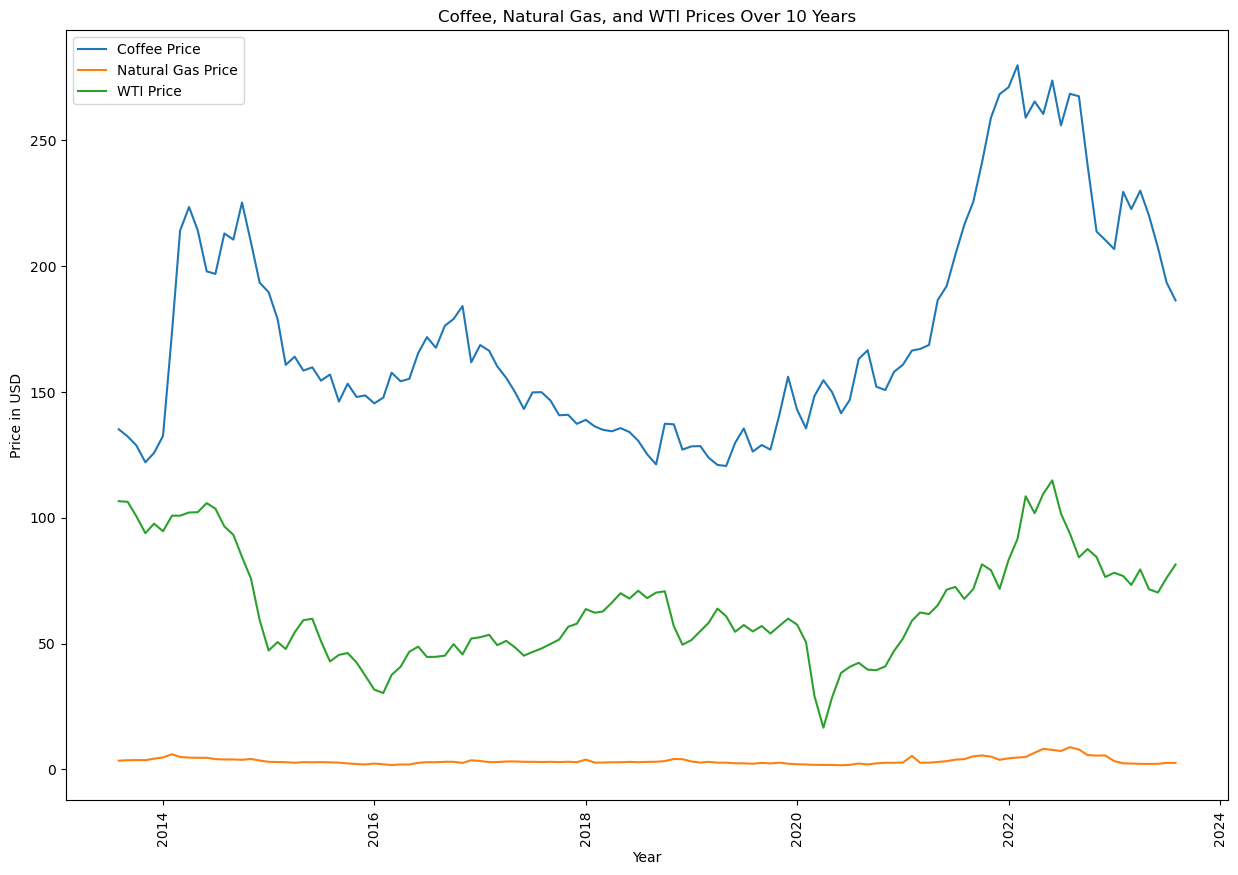

In [103]:
# Make line graph to show price comparisons over 10 years

# Create figure for chart area
fig = plt.figure(figsize=(15,10))

# Plot commodity prices as line graphs
plt.plot(C_Merged_df["Coffee Price"], label = "Coffee Price")
plt.plot(C_Merged_df["Natural Gas Price"], label = "Natural Gas Price")
plt.plot(C_Merged_df["WTI Price"], label = "WTI Price")

# Change xticks rotation
plt.xticks(rotation='vertical')

# Add labels, title, legend
plt.legend()
plt.title('Coffee, Natural Gas, and WTI Prices Over 10 Years')
plt.xlabel("Year")
plt.ylabel("Price in USD")

# Save graph for use in presentation
plt.savefig("Images/Commodity_Line_Graph.png")

plt.show()

In [17]:
# Reduce the size of data for better graphing purposes
Bar_df= C_Merged_df[0:68]

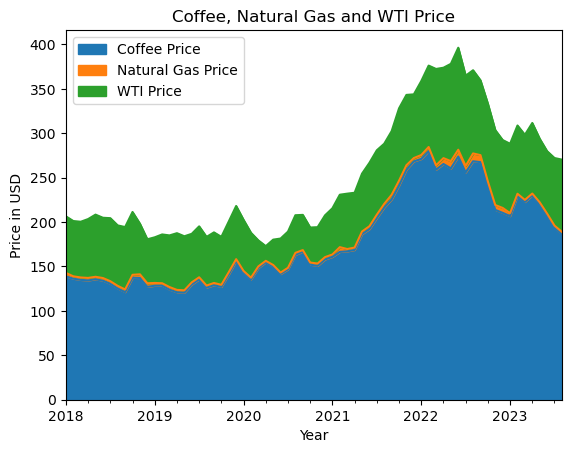

In [104]:
# Create a area chart comparing the commodity prices
Bar_df.plot.area()

# Add labels and title
plt.title('Coffee, Natural Gas and WTI Price')
plt.xlabel("Year")
plt.ylabel("Price in USD")

# Save graph for use in presentation
plt.savefig("Images/Commodity_Area_Graph.png")

plt.show()

In [96]:
# Calculate the correlation of the Commodity data
Correlation_Commodity_stats = C_Merged_df.corr()
Correlation_Commodity_stats = Correlation_Commodity_stats.drop(columns=["Natural Gas Price", "WTI Price"])
Correlation_Commodity_stats

,Coffee Price
Coffee Price,1.000000
Natural Gas Price,0.655807
WTI Price,0.545287


In [22]:
# Clean up and merge stock data with Coffee Price data, while changing the date column to a datetime variable
Filtered_Coffee_df["date"] = pd.to_datetime(Filtered_Coffee_df["date"])
Stock_Coffee_Merged_df = Filtered_Coffee_df.merge(SBUX_df).merge(KDP_df).merge(QSR_df).merge(SJM_df).merge(NSRGY_df)
Stock_Coffee_Merged_df = Stock_Coffee_Merged_df.rename(columns={"value":"Coffee Price"})
SCM_df = Stock_Coffee_Merged_df
Stock_Coffee_Merged_df["date"] = pd.to_datetime(Stock_Coffee_Merged_df["date"])
Stock_Coffee_Merged_df = Stock_Coffee_Merged_df.set_index("date")

C:\Users\Joey\AppData\Local\Temp\ipykernel_21716\3364489672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Filtered_Coffee_df["date"] = pd.to_datetime(Filtered_Coffee_df["date"])


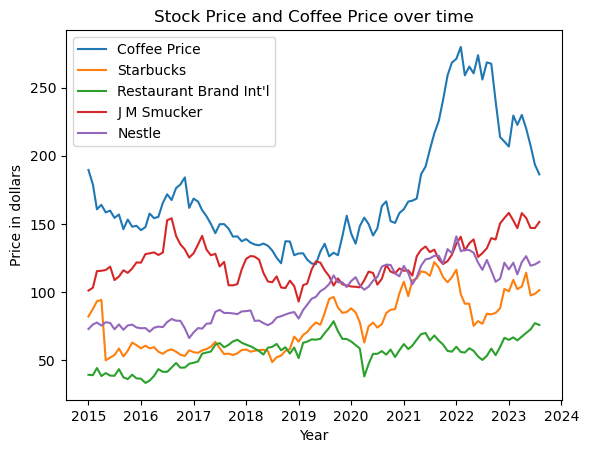

In [105]:
# Plot stock prices and coffee prices as a line graph
plt.plot(Stock_Coffee_Merged_df["Coffee Price"], label = "Coffee Price")
plt.plot(Stock_Coffee_Merged_df["SBUX Price"], label = "Starbucks")
plt.plot(Stock_Coffee_Merged_df["QSR Price"], label = "Restaurant Brand Int'l")
plt.plot(Stock_Coffee_Merged_df["SJM Price"], label = "J M Smucker")
plt.plot(Stock_Coffee_Merged_df["NSRGY Price"], label = "Nestle")

# Set title / axis labels / legend for graph
plt.legend()
plt.xlabel("Year")
plt.ylabel("Price in dollars")
plt.title("Stock Price and Coffee Price over time")

# Save graph for use in presentation
plt.savefig("Images/Stock_Price_Line_Graph.png")

plt.show()

In [98]:
# Calculate the correlation of the Monthly Stock data
Correlation_Stock_stats = Stock_Coffee_Merged_df.corr()
Correlation_Stock_stats = Correlation_Stock_stats["Coffee Price"]
Correlation_Stock_stats.pop("Coffee Price")
# Correlation_Stock_stats.pop("Year")
Correlation_Stock_stats.pop("KDP Price")
Correlation_Stock_stats

SBUX Price     0.556738
QSR Price      0.066442
SJM Price      0.595528
NSRGY Price    0.650358
Name: Coffee Price, dtype: float64

In [77]:
# Filter start date and end date
start_date = "2012-01-01"
end_date = "2022-12-01"

# Filter the date range
filtered_df = SCM_df[(SCM_df["date"] >= start_date) & (SCM_df["date"] <= end_date)]

# Renname the "date" column to "year"
filtered_df = filtered_df.rename(columns={"date":"Year"})

# Convert datetime format to "date" column
filtered_df["Year"] = filtered_df["Year"].dt.year
MBCStock_df = filtered_df

In [78]:
# Create a new dataframe that shows the total of each category per year average
Years = [2015,2016,2017,2018,2019,2020,2021,2022]
Yearly_Stock_data_df = pd.DataFrame()

# Iterate through the monthly dataframe to turn it into a yearly one based on averages
for x in Years:
    df = MBCStock_df[MBCStock_df["Year"] == x]
    df = (df.sum()/12).round(2)
    df = pd.DataFrame(df).T
    Yearly_Stock_data_df = pd.concat([Yearly_Stock_data_df, df], ignore_index=True)

In [79]:
# Clean up the format of the Year column after data transformation
Yearly_Stock_data_df["Year"] = Yearly_Stock_data_df["Year"].astype(int)
Yearly_Stock_data_df["Year"] = Yearly_Stock_data_df["Year"].astype(str)
Yearly_Stock_data_df["Year"] = pd.to_datetime(Yearly_Stock_data_df["Year"])

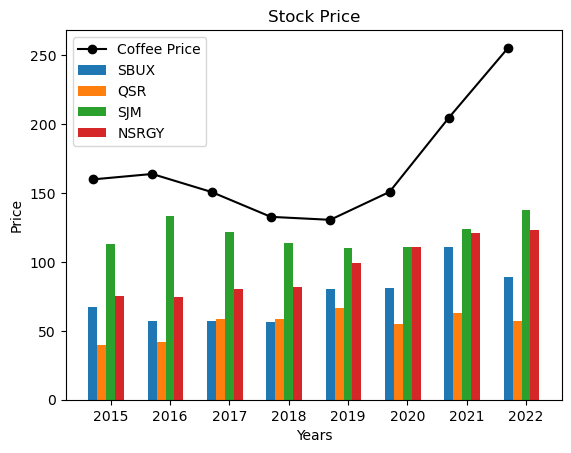

In [106]:
# Import data into variables
categories = Yearly_Stock_data_df["Year"].dt.year
data_set1 = Yearly_Stock_data_df["SBUX Price"]
data_set2 = Yearly_Stock_data_df["QSR Price"]
data_set3 = Yearly_Stock_data_df["SJM Price"]
data_set4 = Yearly_Stock_data_df["NSRGY Price"]

# Set the bar width
bar_width = 0.15  # Adjust the bar width based on your preference

# Set the positions for the bars
bar_positions1 = np.arange(len(categories))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions2 + bar_width
bar_positions4 = bar_positions3 + bar_width

# Create the bar chart
plt.bar(bar_positions1, data_set1, width=bar_width, label='SBUX')
plt.bar(bar_positions2, data_set2, width=bar_width, label='QSR')
plt.bar(bar_positions3, data_set3, width=bar_width, label='SJM')
plt.bar(bar_positions4, data_set4, width=bar_width, label='NSRGY')

# Create a line for Coffee Price for comparison purposes
plt.plot(Yearly_Stock_data_df["Coffee Price"], label = "Coffee Price", marker='o', linestyle='-', color='black')

# Add labels, title, legend and create xticks
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stock Price')
plt.xticks(bar_positions1 + 2 * bar_width, categories)
plt.legend()

# Save graph for use in presentation
plt.savefig("Images/Stock_Multiple_Bar_and_Line_Graph.png")

# Show the plot
plt.show()

In [85]:
# Calculate the correlation of the Yearly Stock data
Correlation_Stock_stats = Yearly_Stock_data_df.corr()
Correlation_Stock_stats = Correlation_Stock_stats["Coffee Price"]
Correlation_Stock_stats.pop("Coffee Price")
Correlation_Stock_stats.pop("Year")
Correlation_Stock_stats.pop("KDP Price")
Correlation_Stock_stats

SBUX Price     0.590587
QSR Price      0.008837
SJM Price      0.776704
NSRGY Price    0.658147
Name: Coffee Price, dtype: float64

In [38]:
# Define lists for iterating through each month of each year
months = ["1","2","3","4","5","6","7","8","9","10","11","12"]
years = ["2020","2021","2022"]

# Create placeholder dictonary to hold final values
data_dict = {}

# Iterate through each month's data in Excel and store the Unemployment amount in a dictonary
for x in years:
    for y in months:
        try:
            data = process_unemployment_data(f'Resources/Unemployment/{x}/covid19-table5-{x}-{y}.xlsx')
            value = data.loc[11, 'Total']
            data_dict[f'{x}-{y}-01'] = value
        except FileNotFoundError:
            print(f'{x}/covid19-table5-{x}-{y}.xlsx has no data')


2020/covid19-table5-2020-1.xlsx has no data
2020/covid19-table5-2020-2.xlsx has no data
2020/covid19-table5-2020-3.xlsx has no data
2020/covid19-table5-2020-4.xlsx has no data
2022/covid19-table5-2022-10.xlsx has no data
2022/covid19-table5-2022-11.xlsx has no data
2022/covid19-table5-2022-12.xlsx has no data


In [39]:
# Clean up Unemployment data and merge with Coffee data while reformating date variables to datetime objects
Unemploy_C_df = pd.DataFrame(data_dict, index=[0]).T
Unemploy_C_df = Unemploy_C_df.reset_index()
Unemploy_C_df["index"] = pd.to_datetime(Unemploy_C_df["index"])
CoffeeForU_df = Filtered_Coffee_df.rename(columns={"value":"Coffee Price"})
Unemploy_C_df = Unemploy_C_df.rename(columns={"index":"date", 0 :"Unemployment Total"})
Unemploy_C_df = Unemploy_C_df.merge(CoffeeForU_df)

<function matplotlib.pyplot.show(close=None, block=None)>

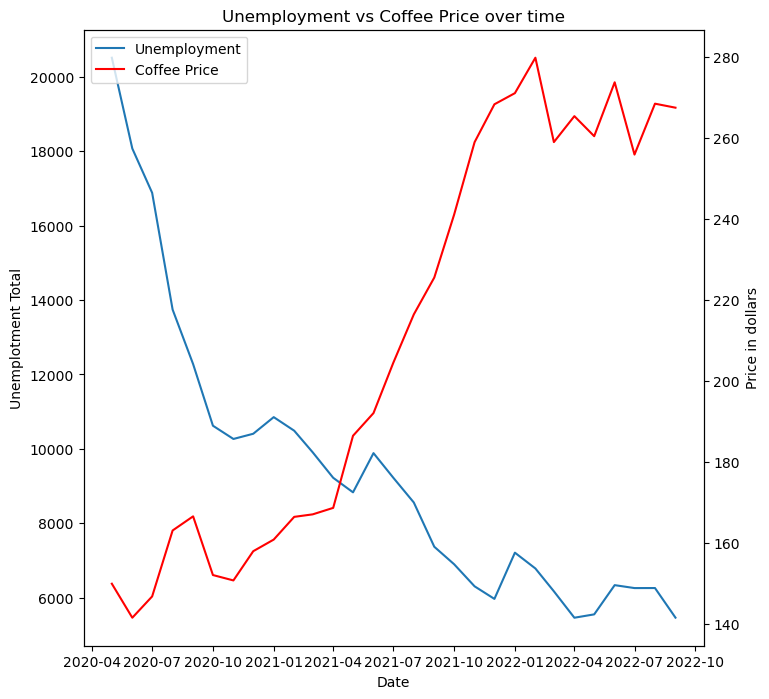

In [107]:
# Create figure for chart area
fig, ax1 = plt.subplots(figsize=(8, 8))

# Create a second twinned chart for second y-axis
ax2 = ax1.twinx()

# Plot both Unemployment and Coffee data as a line graph
p1, = ax1.plot(Unemploy_C_df["date"], Unemploy_C_df["Unemployment Total"], label = "Unemployment")
p2, = ax2.plot(Unemploy_C_df["date"], Unemploy_C_df["Coffee Price"], label ="Coffee Price", color="red")

# Set title / axis labels / legend for graph
plt.legend(handles = [p1,p2])
ax1.set_xlabel("Date")
ax1.set_ylabel("Unemplotment Total")
ax2.set_ylabel("Price in dollars")
plt.title("Unemployment vs Coffee Price over time")

# Save graph for use in presentation
plt.savefig("Images/Unemployment_Line_Graph.png")

plt.show

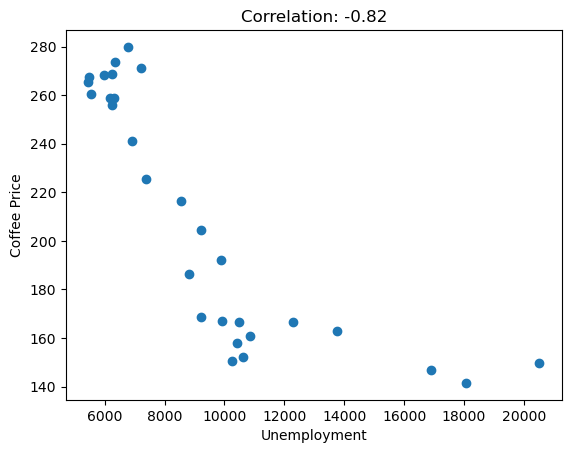

In [108]:
# Calculate the correlation coefficient
correlation_coefficient = Unemploy_C_df['Unemployment Total'].corr(Unemploy_C_df['Coffee Price'])

# Create a scatter plot
plt.scatter(Unemploy_C_df['Unemployment Total'], Unemploy_C_df['Coffee Price'])

# Set title / axis labels for graph
plt.xlabel('Unemployment')
plt.ylabel('Coffee Price')
plt.title(f'Correlation: {correlation_coefficient:.2f}')

# Save graph for use in presentation
plt.savefig("Images/Unemployment_Correlation_ScatterPlot.png")

plt.show()

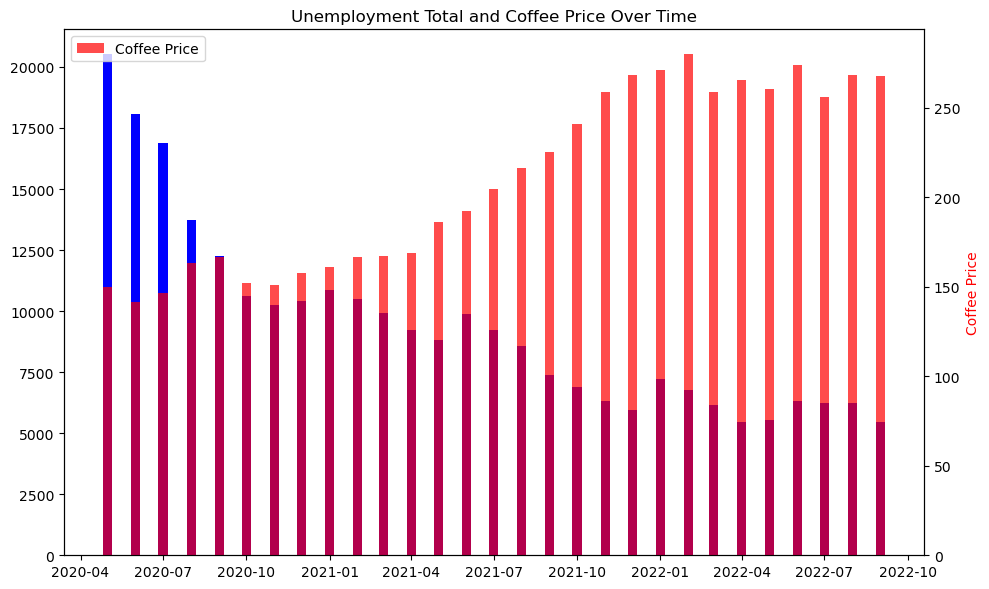

In [109]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the first bar graph for "Unemployment Total"
plt.bar(Unemploy_C_df["date"], Unemploy_C_df["Unemployment Total"], width=10, label="Unemployment Total", color="blue")

# Create the second bar graph for "Coffee Price" on a twinned y-axis
plt.twinx()
plt.bar(Unemploy_C_df["date"], Unemploy_C_df["Coffee Price"], width=10, label="Coffee Price", color="red", alpha=0.7)

# Set labels and titles
plt.ylabel("Unemployment Total", color="blue")
plt.ylabel("Coffee Price", color="red")
plt.xlabel("Dates")
plt.title("Unemployment Total and Coffee Price Over Time")

# Add legends
plt.legend(loc="upper left")

# Save graph for use in presentation
plt.savefig("Images/Unemployment_Overlayed_Bar_Graph.png")

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
# Import Brazil GDP data, and clean it up
csv_path_B = ("Resources/Brazil_GDP_and_Components.csv")
brazil_df = pd.read_csv(csv_path_B, encoding="utf-8")
brazil_df.drop([0,1,2,3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21],inplace=True)
brazil_df.drop("Unnamed: 2", axis=1, inplace=True)
df_B = brazil_df.T
df_B = df_B[[5,7]]
df_B = df_B.reset_index()
df_B = df_B[[5,7]]
df_B = df_B.drop([0,1,2])
df_B = df_B.rename(columns={5:"Year", 7: "Brazil_GDP in Millions"})

In [56]:
# Import Vietnam GDP data, and clean it up
csv_path_V = ("Resources/Vietnam_GDP_and_Components.csv")
vietnam_df = pd.read_csv(csv_path_V, encoding="utf-8")
rows_to_delete = [0,1,2,3,4,5,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
columns_to_delete = ["Unnamed: 0", "Unnamed: 2", "Unnamed: 3", "Unnamed: 15"]
vietnam_df.drop(rows_to_delete, inplace=True)
vietnam_df.drop(columns_to_delete, inplace=True, axis=1)
df_V = vietnam_df.T
df_V = df_V[[6,8]]
df_V = df_V.reset_index()
df_V = df_V[[6,8]]
df_V = df_V.drop([0,1])
df_V = df_V.rename(columns={6:"Year", 8: "Vietnam_GDP in Millions"})

In [57]:
# Import Columbia GDP data, and clean it up
csv_path_C = ("Resources/Colombia_GDP_and_Components.csv")
colombia_df = pd.read_csv(csv_path_C, encoding="utf-8")
rows_to_delete = [0,1,2,3,4,5,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
columns_to_delete = ["Unnamed: 0", "Unnamed: 3", "Unnamed: 4"]
colombia_df.drop(rows_to_delete, inplace=True)
colombia_df.drop(columns_to_delete, inplace=True, axis=1)
df_C = colombia_df.T
df_C = df_C[[6,8]]
df_C = df_C.reset_index()
df_C = df_C[[6,8]]
df_C = df_C.drop([0,1])
df_C = df_C.rename(columns={6:"Year", 8: "Colombia_GDP in Millions"})

In [58]:
# Import Indonesia GDP data, and clean it up
csv_path_I = ("Resources/Indonesia_GDP_and_Components.csv")
indonesia_df = pd.read_csv(csv_path_I, encoding="utf-8")
rows_to_delete = [0,1,2,3,4,5,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
columns_to_delete = ["Unnamed: 0", "Unnamed: 3"]
indonesia_df.drop(rows_to_delete, inplace=True)
indonesia_df.drop(columns_to_delete, inplace=True, axis=1)
df_I = indonesia_df.T
df_I = df_I[[6,8]]
df_I = df_I.reset_index()
df_I = df_I[[6,8]]
df_I = df_I.drop([0,1,2])
df_I = df_I.rename(columns={6:"Year", 8: "Indonesia_GDP in Millions"})

In [65]:
# Filter the Coffee_df DataFrame to select data between August 2013 and August 2022
New_Coffee_df = Coffee_df[Coffee_df.date.between("2013-08-01", "2022-08-01")]

# Filter to retain only rows with date ending in '-08-01"
New_Coffee_df = New_Coffee_df[New_Coffee_df["date"].str.endswith('-08-01')]
New_Coffee_df["date"] = pd.to_datetime(New_Coffee_df["date"])

In [66]:
# Convert datetime format to "date" column
New_Coffee_df["date"] = New_Coffee_df["date"].dt.year

# Rename the "date" column to "Year" and "value" to "Coffee Price"
New_Coffee_df = New_Coffee_df.rename(columns={"date":"Year", "value": "Coffee Price"})

# Convert the "Year" column to a string data type
New_Coffee_df["Year"] = New_Coffee_df["Year"].astype(str)

In [67]:
# Merge together all 4 countries GDP and Coffee Price data to one dataframe
df1 = pd.DataFrame(df_B)
df2 = pd.DataFrame(df_V)
BV_df = df1.merge(df2, how='right')
df3 = pd.DataFrame(BV_df)
df4 = pd.DataFrame(df_C)
BVC_df = df3.merge(df4, how='right')
df5 = pd.DataFrame(BVC_df)
df6 = pd.DataFrame(df_I)
BVCI_df = df5.merge(df6, how='right')
df7 = pd.DataFrame(BVCI_df)
df8 = pd.DataFrame(New_Coffee_df)
BVCI_C_df = df7.merge(df8, how='right')

# Perform data cleaning and conversion or specific columns
BVCI_C_df["Brazil_GDP in Millions"]=BVCI_C_df["Brazil_GDP in Millions"].str.replace(',', '').astype(float)
BVCI_C_df["Vietnam_GDP in Millions"]=BVCI_C_df["Vietnam_GDP in Millions"].str.replace(',', '').astype(float)
BVCI_C_df["Colombia_GDP in Millions"]=BVCI_C_df["Colombia_GDP in Millions"].str.replace(',', '').astype(float)
BVCI_C_df["Indonesia_GDP in Millions"]=BVCI_C_df["Indonesia_GDP in Millions"].str.replace(',', '').astype(float)
BVCI_C_df = BVCI_C_df.sort_values(by=["Year"])

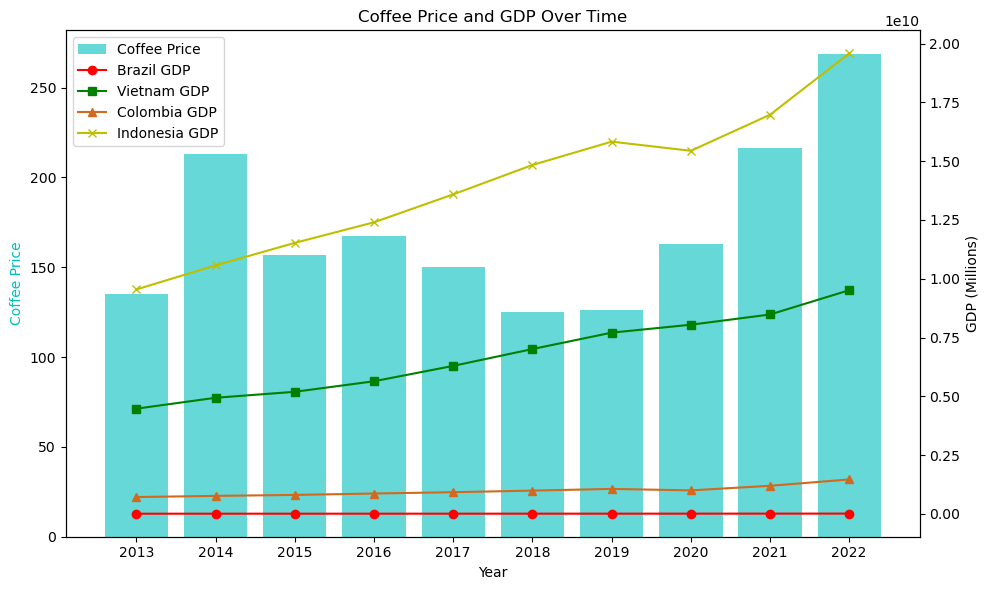

In [110]:
# Extract the data
years = BVCI_C_df["Year"]
coffee_prices = BVCI_C_df["Coffee Price"]
brazil_gdp = BVCI_C_df["Brazil_GDP in Millions"]
vietnam_gdp = BVCI_C_df["Vietnam_GDP in Millions"]
colombia_gdp = BVCI_C_df["Colombia_GDP in Millions"]
indonesia_gdp = BVCI_C_df["Indonesia_GDP in Millions"]

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a bar plot for Coffee Price on the primary y-axis
ax1.bar(years, coffee_prices, label="Coffee Price", color='c', alpha=0.6)

# Set labels for the primary y-axis
ax1.set_xlabel("Year")
ax1.set_ylabel("Coffee Price", color='c')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot line graphs for GDP on the secondary y-axis
ax2.plot(years, BVCI_C_df["Brazil_GDP in Millions"], label="Brazil GDP", marker='o', linestyle='-', color='r')
ax2.plot(years, BVCI_C_df["Vietnam_GDP in Millions"], label="Vietnam GDP", marker='s', linestyle='-', color='g')
ax2.plot(years, BVCI_C_df["Colombia_GDP in Millions"], label="Colombia GDP", marker='^', linestyle='-', color='chocolate')
ax2.plot(years, BVCI_C_df["Indonesia_GDP in Millions"], label="Indonesia GDP", marker='x', linestyle='-', color='y')

# Set labels for the secondary y-axis
ax2.set_ylabel("GDP (Millions)")

# Set the title and legend
plt.title("Coffee Price and GDP Over Time")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save graph for use in presentation
plt.savefig("Images/GDP_Bar_and_Line_Graph.png")

# Adjust subplot params
plt.tight_layout()
plt.show()


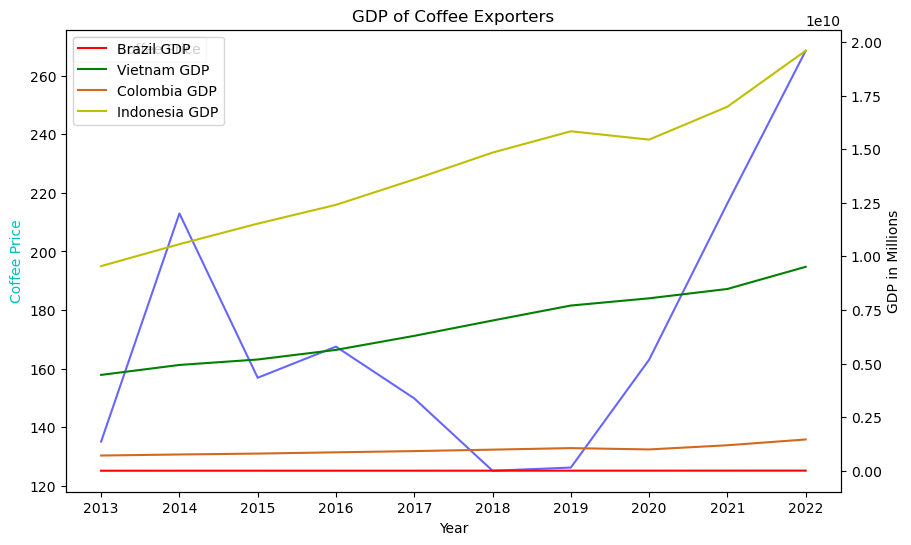

In [111]:
# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a bar plot for Coffee Price on the primary y-axis
ax1.plot(years, coffee_prices, label="Coffee Price", color='b', alpha=0.6)

# Set labels for the primary y-axis
ax1.set_xlabel("Year")
ax1.set_ylabel("Coffee Price", color='c')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(years, BVCI_C_df["Brazil_GDP in Millions"], label="Brazil GDP", color='r')
ax2.plot(years, BVCI_C_df["Vietnam_GDP in Millions"], label="Vietnam GDP",color='g')
ax2.plot(years, BVCI_C_df["Colombia_GDP in Millions"], label="Colombia GDP",color='chocolate')
ax2.plot(years, BVCI_C_df["Indonesia_GDP in Millions"], label="Indonesia GDP", color='y')

# Set the title, legend, and axis labels
plt.xlabel('Year')
plt.ylabel('GDP in Millions')
plt.title("GDP of Coffee Exporters")
plt.legend()
ax1.legend()

# Save graph for use in presentation
plt.savefig("Images/GDP_Line_Graph.png")

plt.show()

In [102]:
# Calculate the correlation of the yearly GDP Stock data
Correlation_GDP_stats = BVCI_C_df.corr()
Correlation_GDP_stats = Correlation_GDP_stats["Coffee Price"]
Correlation_GDP_stats.pop("Coffee Price")
Correlation_GDP_stats.pop("Year")
Correlation_GDP_stats

Brazil_GDP in Millions       0.634914
Vietnam_GDP in Millions      0.459680
Colombia_GDP in Millions     0.611800
Indonesia_GDP in Millions    0.472200
Name: Coffee Price, dtype: float64